# Risk averse Bayesian optimization with input perturbations

This notebook considers risk averse Bayesian optimization of objectives $f(x + \Delta_x)$, where $x$ denotes the design variable and $\Delta_x$ denotes the perturbations to the inputs that are applied at the implementation phase, such as manufacturing errors. 
The design variable $x$ is fully controlled by the practitioner, however, the input perturbation $\Delta_x$ is only controllable at the experimentation phase and is determined by the environment once the decision $x$ is implemented, according to some probability distribution.
This means that while optimizing the design, we can simulate $f(x)$ for any given $x$, however, once the optimization is done, the actual implemented solution becomes $x + \Delta_x$.

In this setting, we want to find high-performing designs that are also robust to the effects of the input perturbations. 
To do so, we will follow the Bayesian optimization of risk measures framework introduced in [1]. 
Please refer to the [Risk averse Bayesian optimization with environmental variables](https://botorch.org/docs/tutorials/risk_averse_bo_with_environmental_variables) notebook for additional background on this.

In this notebook, we will use the `qNoisyExpectedImprovement` acquisition function to optimize the VaR risk measure at risk level $\alpha=0.8$, computed w.r.t. the perturbations in the inputs. To do so, we will:
 - Use `InputPerturbation` input transform to add a set of samples of $\Delta_x$ to each given $x$;
 - Calculate the joint posterior over these samples;
 - Use the `RiskMeasureMCObjective` to convert these joint samples into samples of the risk measure;
 - And use these risk measure samples to define the improvement in `qNoisyExpectedImprovement`.

We will use the (negated) SixHumpCamel test function, and assume that the input perturbations follow a Gaussian distribution with standard deviation of 5% of the parameter space (truncated to the parameter bounds). 
During optimization, we will use 16 (qMC) samples of $\Delta_x$ to approximate the VaR risk measure.

VaR, the Value-at-Risk, is a risk measure that measures the worst possible outcome (small rewards or large losses) after excluding the worst outcomes with a total probability of $1 - \alpha$. 
It is commonly used in finance for risk management, and corresponds to the $1 - \alpha$ quantile of the random variable.

Note: Risk measures are typically studied in the context of a minimization problem (including in [1]), since it makes more sense to minimize "risk", and treat the larger values as being undesirable. Since the default behavior in BoTorch is to maximize the objective, the `RiskMeasureMCObjective` (and its subclasses) is defined w.r.t. the lower tail of the random variable, i.e., by treating the smaller values as undesirable. With this implementation, all that is needed to minimize a risk measure (of the original objective) is to negate the objective, as is done in this notebook.   

[1] [S. Cakmak, R. Astudillo, P. Frazier, and E. Zhou. Bayesian Optimization of Risk Measures. Advances in Neural Information Processing Systems 33, 2020.](https://arxiv.org/abs/2007.05554)

In [1]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [2]:
import os
import warnings
from time import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from botorch import fit_gpytorch_mll
from botorch.acquisition import qNoisyExpectedImprovement, qSimpleRegret
from botorch.acquisition.risk_measures import VaR
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.models.transforms.input import InputPerturbation
from botorch.sampling import SobolQMCNormalSampler
from botorch.optim import optimize_acqf
from botorch.utils.sampling import draw_sobol_samples, draw_sobol_normal_samples
from botorch.utils.transforms import unnormalize
from botorch.test_functions import SixHumpCamel
from gpytorch import ExactMarginalLogLikelihood
from torch import Tensor

%matplotlib inline

warnings.filterwarnings("ignore")

SMOKE_TEST = os.environ.get("SMOKE_TEST")
BATCH_SIZE = 2 if not SMOKE_TEST else 1
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 128 if not SMOKE_TEST else 4
N_W = 16 if not SMOKE_TEST else 2
NUM_ITERATIONS = 25 if not SMOKE_TEST else 2
STD_DEV = 0.05
ALPHA = 0.8

tkwargs = {"device": "cpu", "dtype": torch.double}


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Problem setup
We will initialize the `SixHumpCamel` test function and define a wrapper around it to normalize the domain to $[0, 1]^2$.

In [3]:
test_function = SixHumpCamel(negate=True)
dim = test_function.dim


def evaluate_function(X: Tensor) -> Tensor:
    return test_function(unnormalize(X, test_function.bounds)).view(*X.shape[:-1], 1)

### Model initialization
We will initialize the `SingleTaskGP` model on $8$ Sobol points. 
In doing so, we will also pass in the `InputPerturbation`. We will re-initialize `InputPerturbation` with a new set `perturbation_set` at every model training to ensure adequate coverage of the perturbation space.

In [4]:
bounds = torch.stack([torch.zeros(dim), torch.ones(dim)]).to(**tkwargs)
train_X = draw_sobol_samples(bounds=bounds, n=8, q=1).squeeze(-2).to(**tkwargs)
train_Y = evaluate_function(train_X)


def train_model(train_X: Tensor, train_Y: Tensor) -> SingleTaskGP:
    r"""Returns a `SingleTaskGP` model trained on the inputs"""
    intf = InputPerturbation(
        perturbation_set=draw_sobol_normal_samples(d=dim, n=N_W, **tkwargs) * STD_DEV,
        bounds=bounds,
    )
    model = SingleTaskGP(
        train_X, train_Y, input_transform=intf
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model


model = train_model(train_X, train_Y)

### Define a helper function that performs the BO step
The helper function will initialize the `qNoisyExpectedImprovement` acquisition function with the risk measure objective, and optimize it to find the candidate to evaluate.

In [5]:
risk_measure = VaR(alpha=ALPHA, n_w=N_W)


def optimize_acqf_and_get_observation():
    r"""Optimizes the acquisition function, and returns a new candidate and observation."""
    acqf = qNoisyExpectedImprovement(
        model=model,
        X_baseline=train_X,
        sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
        objective=risk_measure,
        prune_baseline=True,
    )

    candidate, _ = optimize_acqf(
        acq_function=acqf,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )

    new_observations = evaluate_function(candidate)
    return candidate, new_observations

## Perform the Bayesian optimization loop
The BO loop iterates the following steps:
- Given the surrogate model, maximize the acquisition function to find the candidate(s) to evaluate;
- Observe $f(x)$ for each candidate;
- Update the surrogate model with the new observation(s).

Note: Running this may take a while.

In [6]:
start_time = time()

for i in range(NUM_ITERATIONS):
    print(f"Starting iteration {i}, total time: {time() - start_time:.3f} seconds.")
    # optimize the acquisition function and get the observations
    candidate, observations = optimize_acqf_and_get_observation()

    # update the model with new observations
    train_X = torch.cat([train_X, candidate], dim=0)
    train_Y = torch.cat([train_Y, observations], dim=0)
    model = train_model(train_X, train_Y)

Starting iteration 0, total time: 0.000 seconds.


Starting iteration 1, total time: 1.206 seconds.


Starting iteration 2, total time: 2.399 seconds.


Starting iteration 3, total time: 3.719 seconds.


Starting iteration 4, total time: 5.910 seconds.


Starting iteration 5, total time: 7.989 seconds.


Starting iteration 6, total time: 9.804 seconds.


Starting iteration 7, total time: 11.922 seconds.


Starting iteration 8, total time: 14.229 seconds.


Starting iteration 9, total time: 17.317 seconds.


Starting iteration 10, total time: 20.677 seconds.


Starting iteration 11, total time: 22.901 seconds.


Starting iteration 12, total time: 26.342 seconds.


Starting iteration 13, total time: 29.940 seconds.


Starting iteration 14, total time: 33.149 seconds.


Starting iteration 15, total time: 36.942 seconds.


Starting iteration 16, total time: 40.683 seconds.


Starting iteration 17, total time: 43.752 seconds.


Starting iteration 18, total time: 46.817 seconds.


Starting iteration 19, total time: 49.188 seconds.


Starting iteration 20, total time: 54.240 seconds.


Starting iteration 21, total time: 58.107 seconds.


Starting iteration 22, total time: 61.920 seconds.


Starting iteration 23, total time: 65.906 seconds.


Starting iteration 24, total time: 68.461 seconds.


### Find the solution to implement
We will choose the solution to implement as the previously evaluated point that maximizes the posterior expectation of the risk measure. Since this expectation is not available in closed form, we will use its qMC estimate as a surrogate. We will use a larger `perturbation_set` here to get a more precise estimate.

In [7]:
# update the input transform of the already trained model
new_intf = InputPerturbation(
    perturbation_set=draw_sobol_normal_samples(d=dim, n=128, **tkwargs) * STD_DEV,
    bounds=bounds,
).eval()
model.input_transform = new_intf

risk_measure = VaR(alpha=ALPHA, n_w=128)
expected_risk_measure = qSimpleRegret(model=model, objective=risk_measure)

with torch.no_grad():
    expected_rm_values = expected_risk_measure(train_X.unsqueeze(-2))
expected_final_rm, max_idx = expected_rm_values.max(dim=0)
final_candidate = train_X[max_idx]

### Plotting the risk measure corresponding to the best observed point over iterations
As before, we define the best observed point as the previously evaluated point that maximizes the posterior expectation of the risk measure.

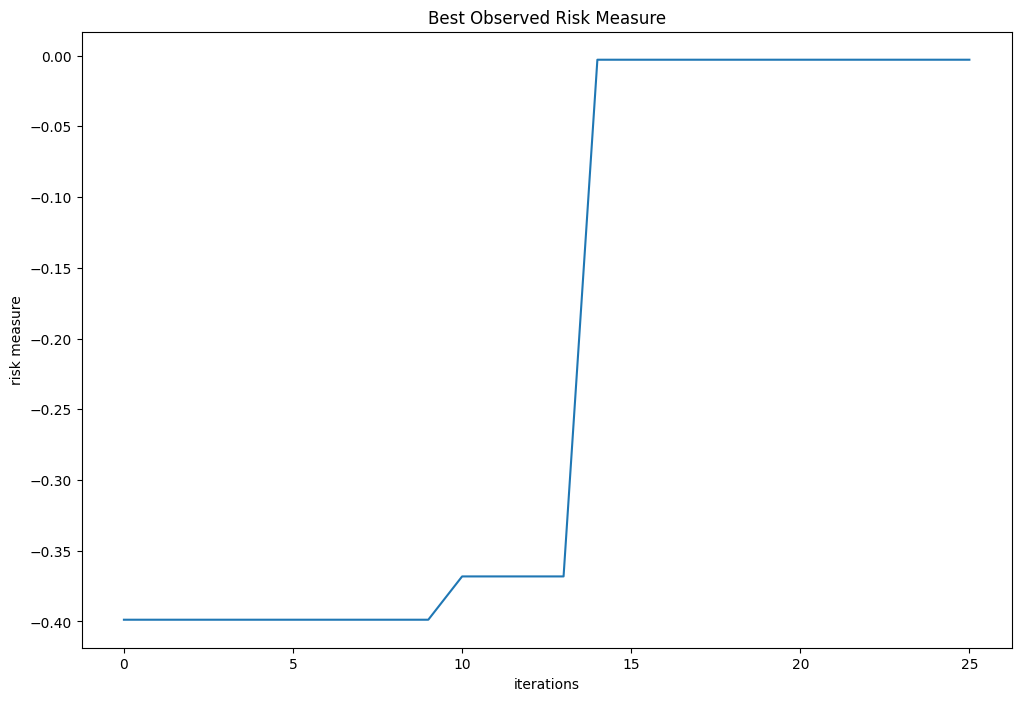

In [8]:
best_observed = torch.zeros(NUM_ITERATIONS + 1, **tkwargs)
for i in range(NUM_ITERATIONS + 1):
    best_observed[i] = expected_rm_values[: 6 + i * BATCH_SIZE].max()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(best_observed)
ax.set_xlabel("iterations")
ax.set_ylabel("risk measure")
ax.set_title("Best Observed Risk Measure")
plt.show()

### Plotting the true risk measure to see how we did
We can use the input transform and the risk measure we previously defined to make this part easier!

We plot both the response surface, $f(x)$, and the risk measure surface, $\rho[f(x + \Delta_x)]$, and mark the best risk averse solution found on both plots. 
The plots are restricted to $[0.3, 0.7]^2$ to highlight more promising areas of the solution space.

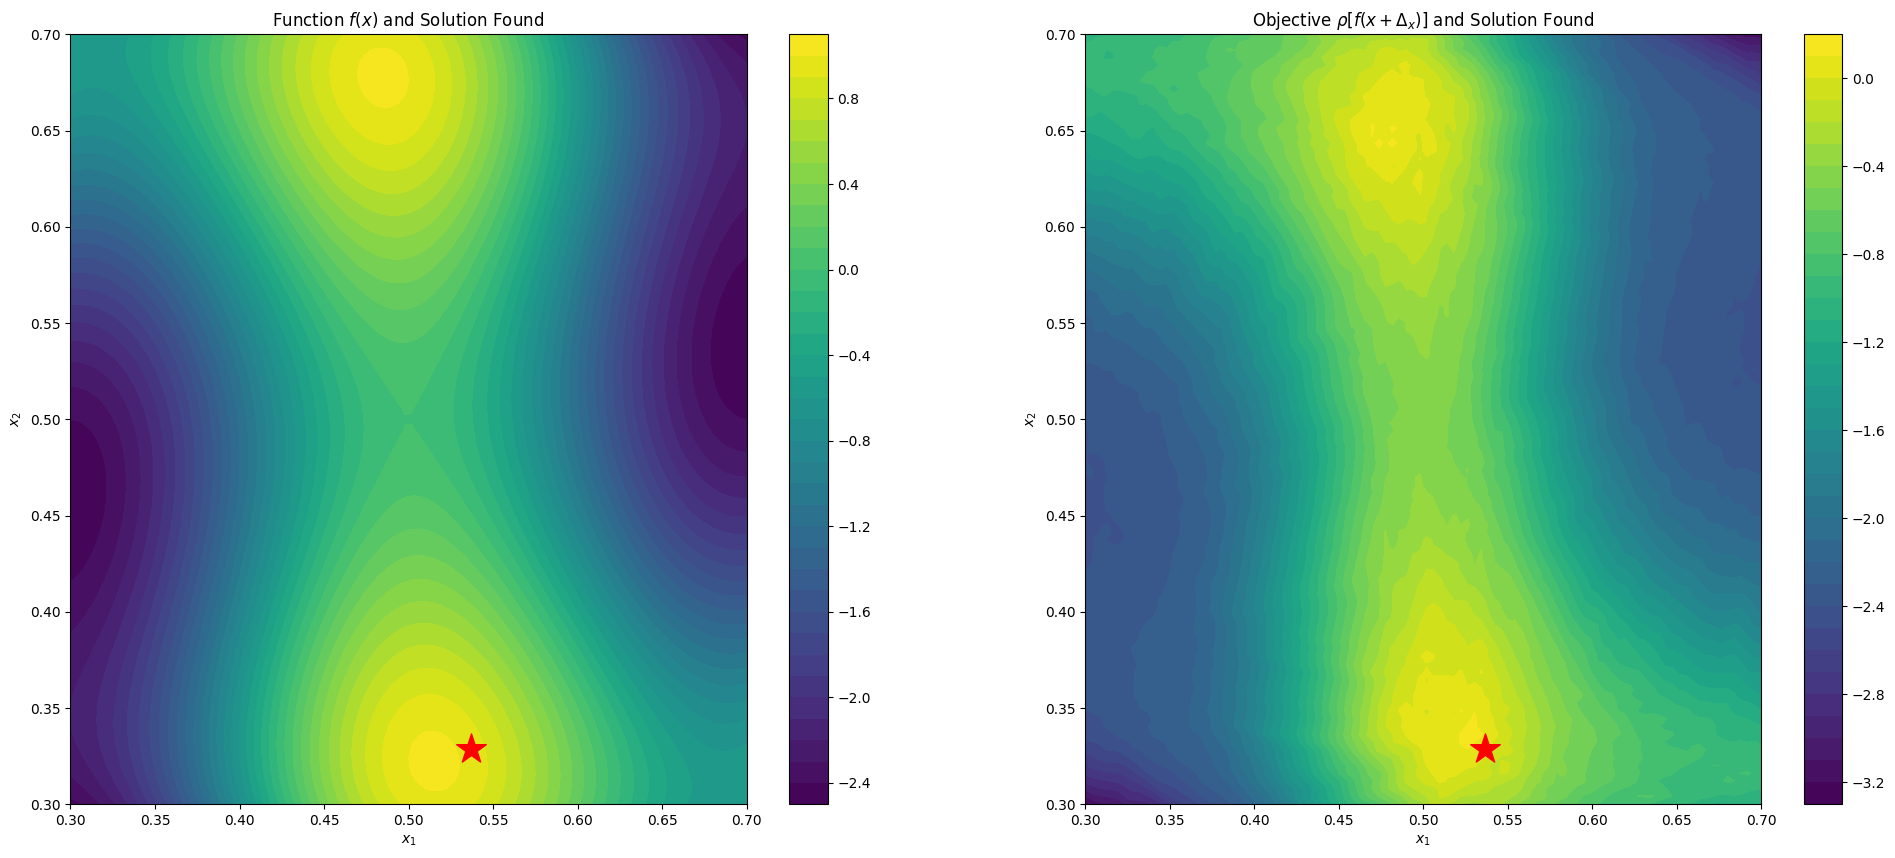

In [9]:
n_plot = 100

fig, axes = plt.subplots(ncols=2, figsize=(24, 10))

for i, ax in enumerate(axes):
    # generate a grid of `x` points to evaluate for plotting
    x_ = np.linspace(0.3, 0.7, n_plot)
    x1, x2 = np.meshgrid(x_, x_)
    eval_x_grid = torch.cat(
        [torch.from_numpy(x1).unsqueeze(-1), torch.from_numpy(x2).unsqueeze(-1)], dim=-1
    )
    if i == 0:
        plot_values = evaluate_function(eval_x_grid).view(n_plot, n_plot)
        ax.set_title("Function $f(x)$ and Solution Found")
    else:
        # add `delta_x` to each point, evalute the objective, and calculate the risk measure
        eval_x_dx = new_intf(eval_x_grid)
        eval_y = evaluate_function(eval_x_dx)
        plot_values = risk_measure(eval_y).view(n_plot, n_plot)
        ax.set_title("Objective $\\rho[f(x + \Delta_x)]$ and Solution Found")
    contours = ax.contourf(x1, x2, plot_values, levels=40)
    plt.colorbar(contours, ax=ax)
    ax.scatter(final_candidate[0], final_candidate[1], marker="*", color="red", s=500)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
plt.show()